In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import math
import os
from pathlib import Path
from tqdm import tqdm
from itertools import combinations
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression 
from pmdarima.arima import ARIMA, auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Dense
import warnings
import logging

warnings.simplefilter("ignore")
mpl.rcParams[u'font.sans-serif'] = ['simhei']
mpl.rcParams['axes.unicode_minus'] = False
logging.basicConfig(level=logging.INFO)
err_log_handler = logging.FileHandler(filename="./results/arima_train_err_log.txt", mode='a')
err_logger = logging.getLogger("arima_train_err")
err_logger.addHandler(err_log_handler)


# %load_ext pycodestyle_magic
# %pycodestyle_on --ignore E501

time: 1.88 s (started: 2022-09-28 17:24:51 +00:00)


# Prepare data

In [2]:
# setting of output files
save_raw_corr_data = True
save_arima_resid_data = True
# data implement setting
data_implement = "paper_eva_5"  # tw50|sp500_20082017|sp500_19972007|tetuan_power
                                   # |paper_eva_1|paper_eva_2|paper_eva_3|paper_eva_4|paper_eva_5
# lstm weight setting
lstm_weight_setting = "sp500_20082017_sorcecodes"  # tw50|sp500_20082017|sp500_20082017_KShyperLSTM|sp500_20082017_sorcecodes
                                        # |sp500_19972007|tetuan_power
# evaluation set setting
items_setting = "test"  # test|all
# data time period setting
time_period = "_test2"

time: 576 µs (started: 2022-09-28 17:24:53 +00:00)


In [3]:
# data loading & implement setting
dataset_path = Path("../dataset/")
if data_implement == "tw50":
    file_name = Path("tw50_hold_20082018_adj_close_pre.csv")
    train_set = ['萬海_adj_close', '豐泰_adj_close', '友達_adj_close', '欣興_adj_close', '台塑化_adj_close', '和泰車_adj_close', '元大金_adj_close', '南電_adj_close', '台塑_adj_close', '統一超_adj_close', '台泥_adj_close', '瑞昱_adj_close', '彰銀_adj_close', '富邦金_adj_close', '研華_adj_close', '中鋼_adj_close', '鴻海_adj_close', '台新金_adj_close', '遠傳_adj_close', '南亞_adj_close', '台達電_adj_close', '台灣大_adj_close', '台化_adj_close', '聯詠_adj_close', '廣達_adj_close', '聯發科_adj_close', '台積電_adj_close', '統一_adj_close', '中信金_adj_close', '長榮_adj_close']
elif data_implement == "sp500_19972007":
    file_name = Path("sp500_hold_19972007_adj_close_pre.csv")
    train_set = ['PXD', 'WAT', 'LH', 'AMGN', 'AOS', 'EFX', 'NEM', 'CTAS', 'MAT', 'VLO', 'APH', 'ADM', 'MLM', 'BK', 'NOV', 'BDX', 'RRC', 'IVZ', 'ED', 'SBUX', 'CI', 'ZION', 'COO', 'FDX', 'GLW', 'GPC', 'HPQ', 'ADI', 'AMG', 'MTB', 'YUM', 'SYK', 'KMX', 'AME', 'BMY', 'KMB', 'JPM', 'AET', 'DLTR', 'MGM', 'FL', 'HD', 'CLX', 'OKE', 'WMB', 'IFF', 'CMS', 'MMC', 'REG', 'ES', 'ITW', 'VRTX', 'QCOM', 'MSI', 'NKTR', 'AMAT', 'BWA', 'ESRX', 'TXT', 'VNO', 'WDC', 'PVH', 'NOC', 'PCAR', 'NSC', 'PHM', 'LUV', 'HUM', 'SPG', 'SJM', 'ABT', 'ALK', 'TAP', 'CAT', 'TMO', 'AES', 'MRK', 'RMD', 'MKC', 'HIG', 'DE', 'ATVI', 'O', 'UNM', 'VMC', 'CMA', 'RHI', 'RE', 'FMC', 'MU', 'CB', 'LNT', 'GE', 'SNA', 'LLY', 'LEN', 'MAA', 'OMC', 'F', 'APA', 'CDNS', 'SLG', 'HP', 'SHW', 'AFL', 'STT', 'PAYX', 'AIG']
elif data_implement in ["sp500_20082017", "paper_eva_1", "paper_eva_2", "paper_eva_3", "paper_eva_4", "paper_eva_5"]:
    file_name = Path("stock08_price.csv")
    train_set = ['CELG', 'PXD', 'WAT', 'LH', 'AMGN', 'AOS', 'EFX', 'CRM', 'NEM', 'JNPR', 'LB', 'CTAS', 'MAT', 'MDLZ', 'VLO', 'APH', 'ADM', 'MLM', 'BK', 'NOV', 'BDX', 'RRC', 'IVZ', 'ED', 'SBUX', 'GRMN', 'CI', 'ZION', 'COO', 'TIF', 'RHT', 'FDX', 'LLL', 'GLW', 'GPN', 'IPGP', 'GPC', 'HPQ', 'ADI', 'AMG', 'MTB', 'YUM', 'SYK', 'KMX', 'AME', 'AAP', 'DAL', 'A', 'MON', 'BRK', 'BMY', 'KMB', 'JPM', 'CCI', 'AET', 'DLTR', 'MGM', 'FL', 'HD', 'CLX', 'OKE', 'UPS', 'WMB', 'IFF', 'CMS', 'ARNC', 'VIAB', 'MMC', 'REG', 'ES', 'ITW', 'NDAQ', 'AIZ', 'VRTX', 'CTL', 'QCOM', 'MSI', 'NKTR', 'AMAT', 'BWA', 'ESRX', 'TXT', 'EXR', 'VNO', 'BBT', 'WDC', 'UAL', 'PVH', 'NOC', 'PCAR', 'NSC', 'UAA', 'FFIV', 'PHM', 'LUV', 'HUM', 'SPG', 'SJM', 'ABT', 'CMG', 'ALK', 'ULTA', 'TMK', 'TAP', 'SCG', 'CAT', 'TMO', 'AES', 'MRK', 'RMD', 'MKC', 'WU', 'ACN', 'HIG', 'TEL', 'DE', 'ATVI', 'O', 'UNM', 'VMC', 'ETFC', 'CMA', 'NRG', 'RHI', 'RE', 'FMC', 'MU', 'CB', 'LNT', 'GE', 'CBS', 'ALGN', 'SNA', 'LLY', 'LEN', 'MAA', 'OMC', 'F', 'APA', 'CDNS', 'SLG', 'HP', 'XLNX', 'SHW', 'AFL', 'STT', 'PAYX', 'AIG', 'FOX', 'MA']
elif data_implement == "tetuan_power":
    file_name = Path("Tetuan City power consumption_pre.csv")
    train_set = ["Temperature", "Humidity", "Wind Speed", "general diffuse flows", "diffuse flows", "Zone 1 Power Consumption", "Zone 2 Power Consumption", "Zone 3 Power Consumption"]
elif data_implement == "bitcoin_nvda":
    file_name = Path("bitcoin_nvda_20122022_pre.csv")
    train_set = []

dataset_df = pd.read_csv(dataset_path/file_name)
dataset_df = dataset_df.set_index('Date')
all_set = list(dataset_df.columns.values)  # all data
test_set = [p for p in all_set if p not in train_set]  # all data - train data
logging.info(f"===== len(train_set): {len(train_set)}, len(all_set): {len(all_set)}, len(test_set): {len(test_set)} =====")

# evaluation set setting
if items_setting == "all":
    items_set = all_set
    output_set_name = "_all"
elif items_setting == "test":
    items_set = test_set
    output_set_name = "_test"

evaluation_info = {"paper_eva_1": {"items": ['PRGO', 'MRO', 'ADP', 'HCP', 'FITB', 'PEG', 'SYMC', 'EOG', 'MDT', 'NI'], "file_name": "paper_eva_1_res"},
                   "paper_eva_2": {"items": ['STI', 'COP', 'MCD', 'AON', 'JBHT', 'DISH', 'GS', 'LRCX', 'CTXS', 'LEG'], "file_name": "paper_eva_2_res"},
                   "paper_eva_3": {"items": ['TJX', 'EMN', 'JCI', 'C', 'BIIB', 'HOG', 'PX', 'PH', 'XEC', 'JEC'], "file_name": "paper_eva_3_res"},
                   "paper_eva_4": {"items": ['ROP', 'AZO', 'URI', 'TROW', 'CMCSA', 'SLB', 'VZ', 'MAC', 'ADS', 'MCK'], "file_name": "paper_eva_4_res"},
                   "paper_eva_5": {"items": ['RL', 'CVX', 'SRE', 'PFE', 'PCG', 'UTX', 'NTRS', 'INCY', 'COP', 'HRL'], "file_name": "paper_eva_5_res"},
                   "tw50": {"items": items_set, "file_name": f"tw50_20082017_res"},
                   "sp500_19972007": {"items": items_set, "file_name": f"sp500_19972007_res"},
                   "sp500_20082017": {"items": items_set, "file_name": f"sp500_20082017_res"},
                   "tetuan_power": {"items": items_set, "file_name":  f"tetuan_power_res"},
                   "bitcoin_nvda": {"items": items_set, "file_name":  f"bicoin_nvda_res"}}
items_implement = evaluation_info[data_implement]['items']
logging.info(f"===== len(evaluation set): {len(items_implement)} =====")

# lstm weight setting
lstm_weight_path = Path("../rebuild_hybrid_model/models/")
if lstm_weight_setting == "sp500_20082017":
    lstm_weight_filepath = lstm_weight_path/"20220909/sp500_20082017_train_res_epoch_43.h5"
    lstm_weight_name = "_sp500_20082017LSTM"
if lstm_weight_setting == "sp500_20082017_sorcecodes":
    lstm_weight_filepath = "../../models/hybrid_LSTM/epoch247.h5"
    lstm_weight_name = "_sp500_20082017sourcecodeLSTM"
elif lstm_weight_setting == "sp500_20082017_KShyperLSTM":
    lstm_weight_filepath = lstm_weight_path/"20220924/Kristian_Senneset_LSTM_hyper_params/sp500_20082017_train_epoch_146.h5"
    lstm_weight_name = "_sp500_20082017_KShyperLSTM"
elif lstm_weight_setting == "tw50":
    lstm_weight_filepath = lstm_weight_path/"20220816/tw50_20082017_epoch_246.h5"
    lstm_weight_name = "_tw50LSTM"
elif lstm_weight_setting == "tetuan_power":
    lstm_weight_filepath = lstm_weight_path/"20220831/tetuan_power_res_epoch_597.h5"
    lstm_weight_name = "_tetuan_powerLSTM"
logging.info(f"===== LSTM weight:{lstm_weight_name} =====")

# setting of name of output files and pictures title
output_file_name = evaluation_info[data_implement]['file_name'] + output_set_name + time_period + lstm_weight_name
fig_title = data_implement + output_set_name + time_period + lstm_weight_name
logging.info(f"===== file_name basis:{output_file_name}, fig_title basis:{fig_title} =====")

# display(dataset_df)
# display(all_set)

INFO:root:===== len(train_set): 150, len(all_set): 446, len(test_set): 296 =====
INFO:root:===== len(evaluation set): 10 =====
INFO:root:===== LSTM weight:_sp500_20082017LSTM =====
INFO:root:===== file_name basis:paper_eva_5_res_test_test2_sp500_20082017LSTM, fig_title basis:paper_eva_5_test_test2_sp500_20082017LSTM =====


time: 107 ms (started: 2022-09-28 17:24:53 +00:00)


In [4]:
def gen_unseen_data_corr(items: list, time_period:str = "_test2", ret_date: bool = False) -> "pd.DataFrame, pd.Series | pd.DataFrame":
    tmp_corr = dataset_df[items[0]].rolling(window=100).corr(dataset_df[items[1]])
    tmp_corr = tmp_corr.iloc[99::100]
    if time_period == "_test2":
        corr_series = tmp_corr[3:24] # correspond to test2_dataset of original paper
    elif time_period == "_test1" :
        corr_series = tmp_corr[2:23] # correspond to test1_dataset of original paper
    elif time_period == "_dev":
        corr_series = tmp_corr[1:22] # correspond to dev_dataset of original paper
    elif time_period == "_train":
        corr_series = tmp_corr[:21] # correspond to train_dataset of original papaer 
    unseen_data_df = pd.DataFrame(corr_series).reset_index().drop(['Date'], axis=1).T
    if ret_date:
        return unseen_data_df, corr_series
    else:
        return unseen_data_df

time: 728 µs (started: 2022-09-28 17:24:53 +00:00)


In [5]:
display(gen_unseen_data_corr([items_implement[0], items_implement[1]], time_period="_test2"))
display(gen_unseen_data_corr([items_implement[0], items_implement[1]], time_period="_test1"))
display(gen_unseen_data_corr([items_implement[0], items_implement[1]], time_period="_dev"))

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.301064,0.870396,0.895088,0.803884,0.763552,0.437946,0.671847,0.239142,0.703358,0.74433,...,0.396555,0.246283,0.103744,0.01833,0.188772,0.739464,-0.214199,0.285949,-0.352241,0.32908


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.64202,0.301064,0.870396,0.895088,0.803884,0.763552,0.437946,0.671847,0.239142,0.703358,...,0.750612,0.396555,0.246283,0.103744,0.01833,0.188772,0.739464,-0.214199,0.285949,-0.352241


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.305758,0.64202,0.301064,0.870396,0.895088,0.803884,0.763552,0.437946,0.671847,0.239142,...,0.74433,0.750612,0.396555,0.246283,0.103744,0.01833,0.188772,0.739464,-0.214199,0.285949


time: 32 ms (started: 2022-09-28 17:24:53 +00:00)


# ARIMA model

In [6]:
def arima_model(dataset: "pd.DataFrame", portfolio: list, overview: bool = False) -> ("np.array", "pd.DataFrame", str):
    model_110 = ARIMA(order=(1, 1, 0), out_of_sample_size=10, mle_regression=True, suppress_warnings=True)
    model_011 = ARIMA(order=(0, 1, 1), out_of_sample_size=10, mle_regression=True, suppress_warnings=True)
    model_111 = ARIMA(order=(1, 1, 1), out_of_sample_size=10, mle_regression=True, suppress_warnings=True)
    model_211 = ARIMA(order=(2, 1, 1), out_of_sample_size=10, mle_regression=True, suppress_warnings=True)
    model_210 = ARIMA(order=(2, 1, 0), out_of_sample_size=10, mle_regression=True, suppress_warnings=True)
    # model_330 = ARIMA(order=(3, 3, 0), out_of_sample_size=0, mle_regression=True, suppress_warnings=True)

    model_dict = {"model_110": model_110, "model_011": model_011, "model_111": model_111, "model_211": model_211, "model_210": model_210}
    # model_dict = {"model_110": model_110, "model_011": model_011, "model_111": model_111}

    tested_models = []
    arima_model = None
    arima_attr_list = ["aic", "arparams", "aroots", "maparams", "maroots", "params", "pvalues"]
    arima_infos = dict(zip(arima_attr_list, [None]*len(arima_attr_list)))
    find_arima_model = False
    for _, corr_series in dataset.iterrows():
        while not find_arima_model:
            try:
                for model_key in model_dict:
                    if model_key not in tested_models:
                        test_model = model_dict[model_key].fit(corr_series[:-1])  # only use first 20 corrletaion coefficient to fit ARIMA model
                        if arima_model is None:
                            arima_model = test_model
                            arima_model_name = model_key
                        elif arima_model.aic() <= test_model.aic():
                            pass
                        else:
                            arima_model = test_model
                            arima_model_name = model_key
                    tested_models.append(model_key)
            except Exception:
                if len(model_dict)-1 != 0:
                    del model_dict[model_key]
                else:
                    err_logger.error(f"fatal error, {portfolio} doesn't have appropriate arima model\n", exc_info=True)
                    raise NotImplementedError(f"fatal error, {portfolio} doesn't have appropriate arima model\n")
            else:
                # model_dict = {"model_110": model_110, "model_011": model_011, "model_111": model_111, "model_211": model_211, "model_210": model_210, "model_330": model_330}
                model_dict = {"model_110": model_110, "model_011": model_011, "model_111": model_111, "model_211": model_211, "model_210": model_210}
                tested_models.clear()
                find_arima_model = True
        try:
            arima_pred = list(arima_model.predict(n_periods=1))
        except Exception:
            err_logger.error(f"{portfolio} in {time_period} be predicted by {arima_model_name}(its aic:{arima_model.aic()}) getting error:\n", exc_info=True)
            raise NotImplementedError(f"{portfolio} in {time_period} be predicted by {arima_model_name}(its aic:{arima_model.aic()}) getting error\n")
        else:
            arima_pred_in_sample = list(arima_model.predict_in_sample())
            arima_pred_in_sample = [np.mean(arima_pred_in_sample[1:])] + arima_pred_in_sample[1:]
            arima_output = arima_pred_in_sample + arima_pred
            arima_output = np.clip(np.array(arima_output), -1, 1)

            arima_resid = pd.Series(np.array(corr_series) - arima_output).iloc[:-1]

            for attr in arima_infos.keys():
                try:
                    arima_infos[attr] = getattr(arima_model, attr)()
                except AttributeError:
                    pass
        finally:
            find_arima_model = False
    if overview:
        plt.plot(arima_output, label="arima_pred")
        plt.plot(dataset.T, label="data")
        plt.plot(arima_resid, label="res")
        plt.legend()
        plt.show()
        plt.close()

    return arima_output, arima_resid, arima_model_name, *[v for k, v in sorted(arima_infos.items(), key=lambda x:x[0])]

time: 2.08 ms (started: 2022-09-28 17:24:53 +00:00)


In [7]:
unseen_data_corr_df = gen_unseen_data_corr([items_implement[0], items_implement[1]], time_period="_test2")
arima_pred, residual, arima_model_name, arima_aic, arima_arparams, arima_aroots, arima_maparams, arima_maroots, arima_params, arima_pvalues = arima_model(unseen_data_corr_df, [items_implement[0], items_implement[1]])
display(len(arima_pred), len(residual))
display(arima_pred, residual)

21

20

array([0.37458672, 0.26161747, 0.5265695 , 0.6099745 , 0.61901539,
       0.60848646, 0.54060199, 0.5199191 , 0.44534054, 0.43460013,
       0.42617751, 0.41628452, 0.37519024, 0.32579968, 0.27043928,
       0.21412066, 0.17308318, 0.16712131, 0.10637046, 0.07643581,
       0.01540436])

0    -0.073523
1     0.608779
2     0.368518
3     0.193909
4     0.144537
5    -0.170540
6     0.131245
7    -0.280777
8     0.258017
9     0.309730
10    0.324435
11   -0.019729
12   -0.128908
13   -0.222055
14   -0.252110
15   -0.025348
16    0.566381
17   -0.381320
18    0.179579
19   -0.428676
dtype: float64

time: 222 ms (started: 2022-09-28 17:24:53 +00:00)


# LSTM

In [8]:
def double_tanh(x):
    return (tf.math.tanh(x) * 2)


lstm_model = load_model(lstm_weight_filepath, custom_objects={'double_tanh':double_tanh})

2022-09-28 17:24:53.945832: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-28 17:24:53.949950: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-28 17:24:53.950172: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-28 17:24:53.951280: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

time: 717 ms (started: 2022-09-28 17:24:53 +00:00)


# Hybrid model

In [9]:
def stl_decompn(corr_series: "pd.Series", overview: bool = False) -> (float, float, float):
    output_resid = 100000
    output_trend = None
    output_period = None
    for p in range(2, 11):
        decompose_result_mult = seasonal_decompose(corr_series, period=p)
        resid_sum = np.abs(decompose_result_mult.resid).sum()
        if output_resid > resid_sum:
            output_resid = resid_sum
            output_trend = decompose_result_mult.trend.dropna()
            output_period = p

    reg = LinearRegression().fit(np.arange(len(output_trend)).reshape(-1, 1), output_trend)

    if overview:
        decompose_result_mult = seasonal_decompose(corr_series, period=output_period)
        trend = decompose_result_mult.trend.dropna().reset_index(drop=True)
        plt.figure(figsize=(7, 1))
        plt.plot(trend)
        plt.plot([0, len(trend)], [reg.intercept_, reg.intercept_+len(trend)*reg.coef_])
        plt.title("trend & regression line")
        plt.show()
        plt.close()
        decompose_result_mult.plot()
        plt.show()
        plt.close()

    return output_period, output_resid, output_trend.std(), reg.coef_[0]

time: 915 µs (started: 2022-09-28 17:24:54 +00:00)


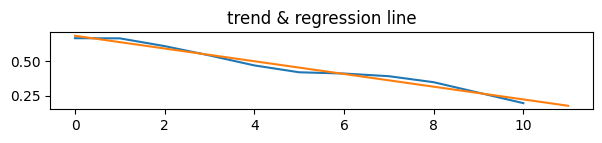

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

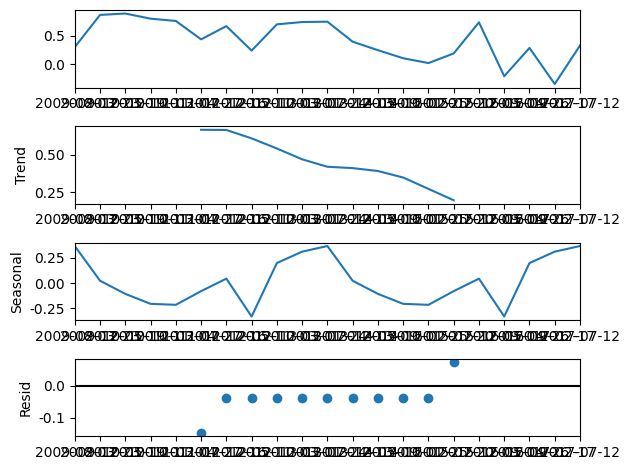

(10, 0.5463782504451181, 0.15478694088176692, -0.04606928854340583)

time: 402 ms (started: 2022-09-28 17:24:54 +00:00)


In [10]:
unseen_data_corr_df, unseen_data_corr_series = gen_unseen_data_corr([items_implement[0], items_implement[1]], ret_date=True)
stl_decompn(unseen_data_corr_series, overview=True)

In [11]:
res_list = []
unseen_data_corr_df_concat = pd.DataFrame(columns=list(range(21))+['items'])
unseen_data_arima_resid_concat = pd.DataFrame(columns=list(range(20))+['items'])
count = 0
for items in tqdm(combinations(items_implement, 2)):
    unseen_data_corr_df, unseen_data_corr_series = gen_unseen_data_corr(items, time_period=time_period, ret_date=True)
    try:
        arima_pred, residual, arima_model_name, arima_aic, arima_arparams, arima_aroots, arima_maparams, arima_maroots, arima_params, arima_pvalues = arima_model(unseen_data_corr_df, items)
    except NotImplementedError:
        continue
    else:
        unseen_res = residual.values.reshape((-1, 20, 1))
        lstm_pred = lstm_model.predict(unseen_res)
        season_period, stl_resid, stl_trend_std, coef_reg_trend = stl_decompn(unseen_data_corr_series)
        items_res_dic = {"items": f"{items[0]} & {items[1]}",
                         "corr_ser_mean": unseen_data_corr_series.mean(),
                         "corr_ser_std": unseen_data_corr_series.std(),
                         "corr_season_period": season_period,
                         "corr_stl_resid": stl_resid,
                         "corr_stl_trend_std": stl_trend_std,
                         "corr_trend_coef": coef_reg_trend,
                         "arima_model": arima_model_name,
                         "arima_aic": arima_aic,
                         "arima_arparams": arima_arparams,
                         "arima_aroots": arima_aroots,
                         "arima_maparams": arima_maparams,
                         "arima_maroots": arima_maroots,
                         "arima_params": arima_params,
                         "arima_pvalues": arima_pvalues,
                         "lstm_pred": lstm_pred[0][0],
                         "arima_pred": arima_pred[-1],
                         "ground_truth": unseen_data_corr_df.iloc[0, -1]}

        res_list.append(items_res_dic)
        unseen_data_corr_df['items'] = f"{items[0]} & {items[1]}"
        unseen_data_corr_df_concat = pd.concat([unseen_data_corr_df_concat, unseen_data_corr_df])
        residual['items'] = f"{items[0]} & {items[1]}"
        unseen_data_arima_resid_concat = pd.concat([unseen_data_arima_resid_concat, residual])

if save_raw_corr_data:
    unseen_data_corr_df_concat = unseen_data_corr_df_concat.set_index('items')
    unseen_data_corr_df_concat.to_csv(f"./results/{output_file_name}_raw_corr.csv", index=True)

if save_arima_resid_data:
    unseen_data_arima_resid_concat = unseen_data_arima_resid_concat.set_index('items')
    unseen_data_arima_resid_concat.to_csv(f"./results/{output_file_name}_arima_resid.csv", index=True)

0it [00:00, ?it/s]

1/1 [==============================] - 1s 535ms/step


2022-09-28 17:24:55.888182: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
1it [00:00,  1.28it/s]

1/1 [==============================] - 0s 13ms/step


2it [00:01,  2.04it/s]

1/1 [==============================] - 0s 14ms/step


3it [00:01,  2.60it/s]

1/1 [==============================] - 0s 13ms/step


4it [00:01,  2.80it/s]

1/1 [==============================] - 0s 13ms/step


5it [00:01,  2.85it/s]

1/1 [==============================] - 0s 13ms/step


6it [00:02,  3.07it/s]

1/1 [==============================] - 0s 12ms/step


7it [00:02,  3.20it/s]

1/1 [==============================] - 0s 13ms/step


8it [00:02,  3.28it/s]

1/1 [==============================] - 0s 13ms/step


9it [00:03,  3.54it/s]

1/1 [==============================] - 0s 13ms/step


10it [00:03,  3.50it/s]

1/1 [==============================] - 0s 14ms/step


11it [00:03,  3.58it/s]

1/1 [==============================] - 0s 13ms/step


12it [00:03,  3.62it/s]

1/1 [==============================] - 0s 14ms/step


13it [00:04,  3.53it/s]

1/1 [==============================] - 0s 13ms/step


14it [00:04,  3.47it/s]

1/1 [==============================] - 0s 13ms/step


15it [00:04,  3.51it/s]

1/1 [==============================] - 0s 14ms/step


16it [00:05,  3.18it/s]

1/1 [==============================] - 0s 14ms/step


17it [00:05,  3.24it/s]

1/1 [==============================] - 0s 14ms/step


18it [00:05,  2.97it/s]

1/1 [==============================] - 0s 13ms/step


19it [00:06,  3.16it/s]

1/1 [==============================] - 0s 13ms/step


20it [00:06,  3.22it/s]

1/1 [==============================] - 0s 13ms/step


21it [00:06,  3.15it/s]

1/1 [==============================] - 0s 13ms/step


22it [00:07,  3.21it/s]

1/1 [==============================] - 0s 12ms/step


23it [00:07,  3.22it/s]

1/1 [==============================] - 0s 13ms/step


24it [00:07,  3.35it/s]

1/1 [==============================] - 0s 14ms/step


25it [00:07,  3.29it/s]

1/1 [==============================] - 0s 14ms/step


26it [00:08,  3.38it/s]

1/1 [==============================] - 0s 13ms/step


27it [00:08,  3.30it/s]

1/1 [==============================] - 0s 13ms/step


28it [00:08,  3.30it/s]

1/1 [==============================] - 0s 13ms/step


29it [00:09,  3.31it/s]

1/1 [==============================] - 0s 13ms/step


30it [00:09,  3.45it/s]

1/1 [==============================] - 0s 13ms/step


31it [00:09,  3.43it/s]

1/1 [==============================] - 0s 14ms/step


32it [00:09,  3.40it/s]

1/1 [==============================] - 0s 13ms/step


33it [00:10,  3.41it/s]

1/1 [==============================] - 0s 13ms/step


34it [00:10,  3.40it/s]

1/1 [==============================] - 0s 13ms/step


35it [00:10,  3.37it/s]

1/1 [==============================] - 0s 13ms/step


36it [00:11,  3.42it/s]

1/1 [==============================] - 0s 13ms/step


37it [00:11,  3.48it/s]

1/1 [==============================] - 0s 13ms/step


38it [00:11,  3.48it/s]

1/1 [==============================] - 0s 13ms/step


39it [00:11,  3.59it/s]

1/1 [==============================] - 0s 13ms/step


40it [00:12,  3.67it/s]

1/1 [==============================] - 0s 12ms/step


41it [00:12,  3.51it/s]

1/1 [==============================] - 0s 13ms/step


42it [00:12,  3.52it/s]

1/1 [==============================] - 0s 13ms/step


43it [00:13,  3.51it/s]

1/1 [==============================] - 0s 13ms/step


44it [00:13,  3.42it/s]

1/1 [==============================] - 0s 13ms/step


45it [00:13,  3.28it/s]

time: 13.7 s (started: 2022-09-28 17:24:55 +00:00)


In [12]:
res_df = pd.DataFrame(res_list)
res_df.to_csv(f"./results/{output_file_name}.csv", index=False)

time: 11.2 ms (started: 2022-09-28 17:25:08 +00:00)


# Display results

In [13]:
res_df = pd.read_csv(f"./results/{output_file_name}.csv")
display(res_df)

,items,corr_ser_mean,corr_ser_std,corr_season_period,corr_stl_resid,corr_stl_trend_std,corr_trend_coef,arima_model,arima_aic,arima_arparams,arima_aroots,arima_maparams,arima_maroots,arima_params,arima_pvalues,lstm_pred,arima_pred,ground_truth
0,RL & CVX,0.424903,0.358556,10,0.546378,0.154787,-0.046069,model_011,13.922722,NaN,[],[-0.99245893],[1.00759837],[-0.03944619 -0.99245893 0.06952699],[1.42298545e-04 8.70198481e-01 8.69079323e-01],0.551237,0.015404,0.329080
1,RL & SRE,0.190953,0.505713,10,0.682961,0.121800,-0.033396,model_011,30.299405,NaN,[],[-0.99724766],[1.00275994],[-0.03700268 -0.99724766 0.17612592],[0.06296489 0.94939447 0.94939682],0.275820,-0.155702,-0.646733
2,RL & PFE,0.315684,0.383996,9,0.640048,0.106715,-0.026128,model_011,24.344422,NaN,[],[-0.99655778],[1.00345411],[-0.02003715 -0.99655778 0.13113843],[0.2501862 0.93259109 0.93172724],0.405101,0.086657,0.688240
3,RL & PCG,0.118185,0.502704,10,0.171971,0.095152,-0.026904,model_111,30.379956,NaN,[-0.38481334],[-0.99639868],[1.00361434],[-0.04615188 -0.38481334 -0.99639868 0.15881952],[0.11435234 0.23225668 0.94568213 0.94509442],0.397426,0.065235,-0.363489
4,RL & UTX,0.358892,0.568486,10,0.695509,0.267087,-0.079783,model_110,26.507600,NaN,[-0.57495242],[],[],[-0.0738136 -0.57495242 0.15522004],[4.04173059e-01 2.42215381e-04 7.94857945e-03],0.259053,0.217060,-0.706079
5,RL & NTRS,0.246737,0.479720,10,0.661138,0.071518,-0.004433,model_011,34.003816,NaN,[],[-0.99704428],[1.00296448],[ 0.00745986 -0.99704428 0.21885497],[0.78655717 0.92643612 0.92553627],0.188739,0.356552,-0.383607
6,RL & INCY,0.171013,0.510106,10,0.648455,0.091230,-0.021144,model_011,35.562524,NaN,[],[-0.99719755],[1.00281032],[-0.02969586 -0.99719755 0.23125993],[0.18305546 0.93857947 0.93816408],0.567905,-0.142702,0.209279
7,RL & COP,0.383459,0.417165,10,1.394751,0.166667,-0.048037,model_011,19.758224,NaN,[],[-0.99696777],[1.00304146],[-0.04720106 -0.99696777 0.09784997],[4.71769036e-06 8.91945742e-01 8.91995726e-01],0.185366,-0.119787,0.536173
8,RL & HRL,0.255742,0.429680,10,0.430691,0.144993,-0.043015,model_011,25.258978,NaN,[],[-0.99765685],[1.00234865],[-0.04053757 -0.99765685 0.13841751],[0.01028929 0.96481007 0.96498389],0.488974,-0.172420,0.306074
9,CVX & SRE,0.339658,0.408272,10,1.302155,0.054176,-0.003122,model_011,23.383837,NaN,[],[-0.99658911],[1.00342256],[-0.00412551 -0.99658911 0.12532308],[0.76273544 0.89273152 0.89346228],0.090746,0.343891,-0.611277


time: 19.6 ms (started: 2022-09-28 17:25:08 +00:00)


In [14]:
def res_df_postprocess(target_df: pd.core.frame.DataFrame) -> None:
    target_df["hybrid_model_pred"] =  target_df["arima_pred"] + target_df["lstm_pred"]
    target_df["error"] = target_df["ground_truth"] - target_df["hybrid_model_pred"]
    target_df["absolute_err"] = target_df["error"].abs()
    target_df['arima_pred_dir'] = np.sign(target_df['ground_truth'] * target_df['arima_pred'])
    target_df['arima_err'] = target_df['ground_truth'] - target_df['arima_pred']
    target_df["lstm_compensation_dir"] = np.sign(target_df['arima_err']) * np.sign(target_df['lstm_pred'])
    quantile_mask = np.logical_and(res_df['error'] < np.quantile(res_df['error'], 0.75), res_df['error'] > np.quantile(res_df['error'], 0.25)).tolist()
    display(np.quantile(res_df['error'], 0.75), np.quantile(res_df['error'], 0.25))
    target_df['high_pred_performance'] = quantile_mask
    target_df['items[0]'] = target_df.apply(lambda row:row['items'].split(" & ")[0], axis=1)
    target_df['items[1]'] = target_df.apply(lambda row:row['items'].split(" & ")[1], axis=1)


res_df_postprocess(res_df)
display(res_df)

-0.23756104127441535

-1.2235419489294221

,items,corr_ser_mean,corr_ser_std,corr_season_period,corr_stl_resid,corr_stl_trend_std,corr_trend_coef,arima_model,arima_aic,arima_arparams,...,ground_truth,hybrid_model_pred,error,absolute_err,arima_pred_dir,arima_err,lstm_compensation_dir,high_pred_performance,items[0],items[1]
0,RL & CVX,0.424903,0.358556,10,0.546378,0.154787,-0.046069,model_011,13.922722,NaN,...,0.329080,0.566641,-0.237561,0.237561,1.0,0.313676,1.0,False,RL,CVX
1,RL & SRE,0.190953,0.505713,10,0.682961,0.121800,-0.033396,model_011,30.299405,NaN,...,-0.646733,0.120118,-0.766851,0.766851,1.0,-0.491032,-1.0,True,RL,SRE
2,RL & PFE,0.315684,0.383996,9,0.640048,0.106715,-0.026128,model_011,24.344422,NaN,...,0.688240,0.491758,0.196482,0.196482,1.0,0.601583,1.0,False,RL,PFE
3,RL & PCG,0.118185,0.502704,10,0.171971,0.095152,-0.026904,model_111,30.379956,NaN,...,-0.363489,0.462661,-0.826150,0.826150,-1.0,-0.428725,-1.0,True,RL,PCG
4,RL & UTX,0.358892,0.568486,10,0.695509,0.267087,-0.079783,model_110,26.507600,NaN,...,-0.706079,0.476113,-1.182192,1.182192,-1.0,-0.923139,-1.0,True,RL,UTX
5,RL & NTRS,0.246737,0.479720,10,0.661138,0.071518,-0.004433,model_011,34.003816,NaN,...,-0.383607,0.545291,-0.928897,0.928897,-1.0,-0.740159,-1.0,True,RL,NTRS
6,RL & INCY,0.171013,0.510106,10,0.648455,0.091230,-0.021144,model_011,35.562524,NaN,...,0.209279,0.425203,-0.215925,0.215925,-1.0,0.351981,1.0,False,RL,INCY
7,RL & COP,0.383459,0.417165,10,1.394751,0.166667,-0.048037,model_011,19.758224,NaN,...,0.536173,0.065579,0.470594,0.470594,-1.0,0.655960,1.0,False,RL,COP
8,RL & HRL,0.255742,0.429680,10,0.430691,0.144993,-0.043015,model_011,25.258978,NaN,...,0.306074,0.316554,-0.010480,0.010480,-1.0,0.478494,1.0,False,RL,HRL
9,CVX & SRE,0.339658,0.408272,10,1.302155,0.054176,-0.003122,model_011,23.383837,NaN,...,-0.611277,0.434636,-1.045913,1.045913,-1.0,-0.955167,-1.0,True,CVX,SRE


time: 29.9 ms (started: 2022-09-28 17:25:08 +00:00)


In [15]:
def plot_exploration(target_df: pd.core.frame.DataFrame, title: str) -> None:
    fig, axes = plt.subplots(figsize=(20, 20), nrows=7, ncols=2, sharex=False, sharey=False, dpi=100)
    s0 = axes[0, 0]
    s0.set_title("ABS_err violin")
    sns.violinplot(y=target_df["absolute_err"], ax=s0)
    s1 = axes[0, 1]
    s1.set_title("Err violin")
    sns.violinplot(y=target_df["error"], ax=s1)
    s2 = axes[1, 0]
    s2.set_title("ABS_err hist")
    target_df['absolute_err'].hist(bins=[b/10 for b in range(11)], ax=s2)
    s3 = axes[1, 1]
    s3.set_title("Err hist")
    target_df['error'].hist(bins=[b/10 for b in range(-10, 11)], ax=s3)
    s4 = axes[2, 0]
    s4.set_title("LSTM_compensation_dir count")
    sns.countplot(x="lstm_compensation_dir", data=target_df, ax=s4)
    s5 = axes[2, 1]
    s5.set_title("LSTM_compensation_dir count groupby ARIMA_pred_dir")
    df_gb = target_df.groupby(['arima_pred_dir', 'lstm_compensation_dir']).size().unstack(level=1)
    df_gb.plot(kind='bar', ax=s5)
    s6 = axes[3, 0]
    s6.set_title("ARIMA_model prediction Err violin group by LSTM_compensation_dir")
    sns.violinplot(x=target_df["lstm_compensation_dir"], y=target_df["arima_err"], ax=s6)
    s8 = axes[4, 0]
    s8.set_title("ARIMA_model prediction magnitude group by LSTM_compensation_dir")
    sns.violinplot(x=target_df["lstm_compensation_dir"], y=target_df["arima_pred"], ax=s8)
    s9 = axes[4, 1]
    s9.set_title("LSTM compensation magnitude group by LSTM_compensation_dir")
    sns.violinplot(x=target_df["lstm_compensation_dir"], y=target_df["lstm_pred"], ax=s9)
    s10 = axes[5, 0]
    s10.set_title("Correlation magnitude in last period group by LSTM_compensation_dir")
    sns.violinplot(x=target_df["lstm_compensation_dir"], y=target_df["ground_truth"], ax=s10)
    s11 = axes[5, 1]
    s11.set_title("Hybrid Err violin group by LSTM_compensation_dir")
    sns.violinplot(x=target_df["lstm_compensation_dir"], y=target_df["error"], ax=s11)
    s12 = axes[6,0]
    s12.set_title("LSTM_compensation_dir pie with wrong ARIMA_pred_dir")
    df_gb.loc[df_gb.index==-1, :].squeeze().plot(kind="pie", autopct='%1.1f%%', ax=s12)
    s13 = axes[6,1]
    s13.set_title("LSTM_compensation_dir pie with correct ARIMA_pred_dir")
    df_gb.loc[df_gb.index==1, :].squeeze().plot(kind="pie", autopct='%1.1f%%', ax=s13)

    fig.suptitle(f"{title}_basic_exploration")
    plt.tight_layout()
    plt.savefig(f"./results/hybrid_prediction_analysis_{title}.png")
    plt.show()
    plt.close()

time: 1.6 ms (started: 2022-09-28 17:25:09 +00:00)


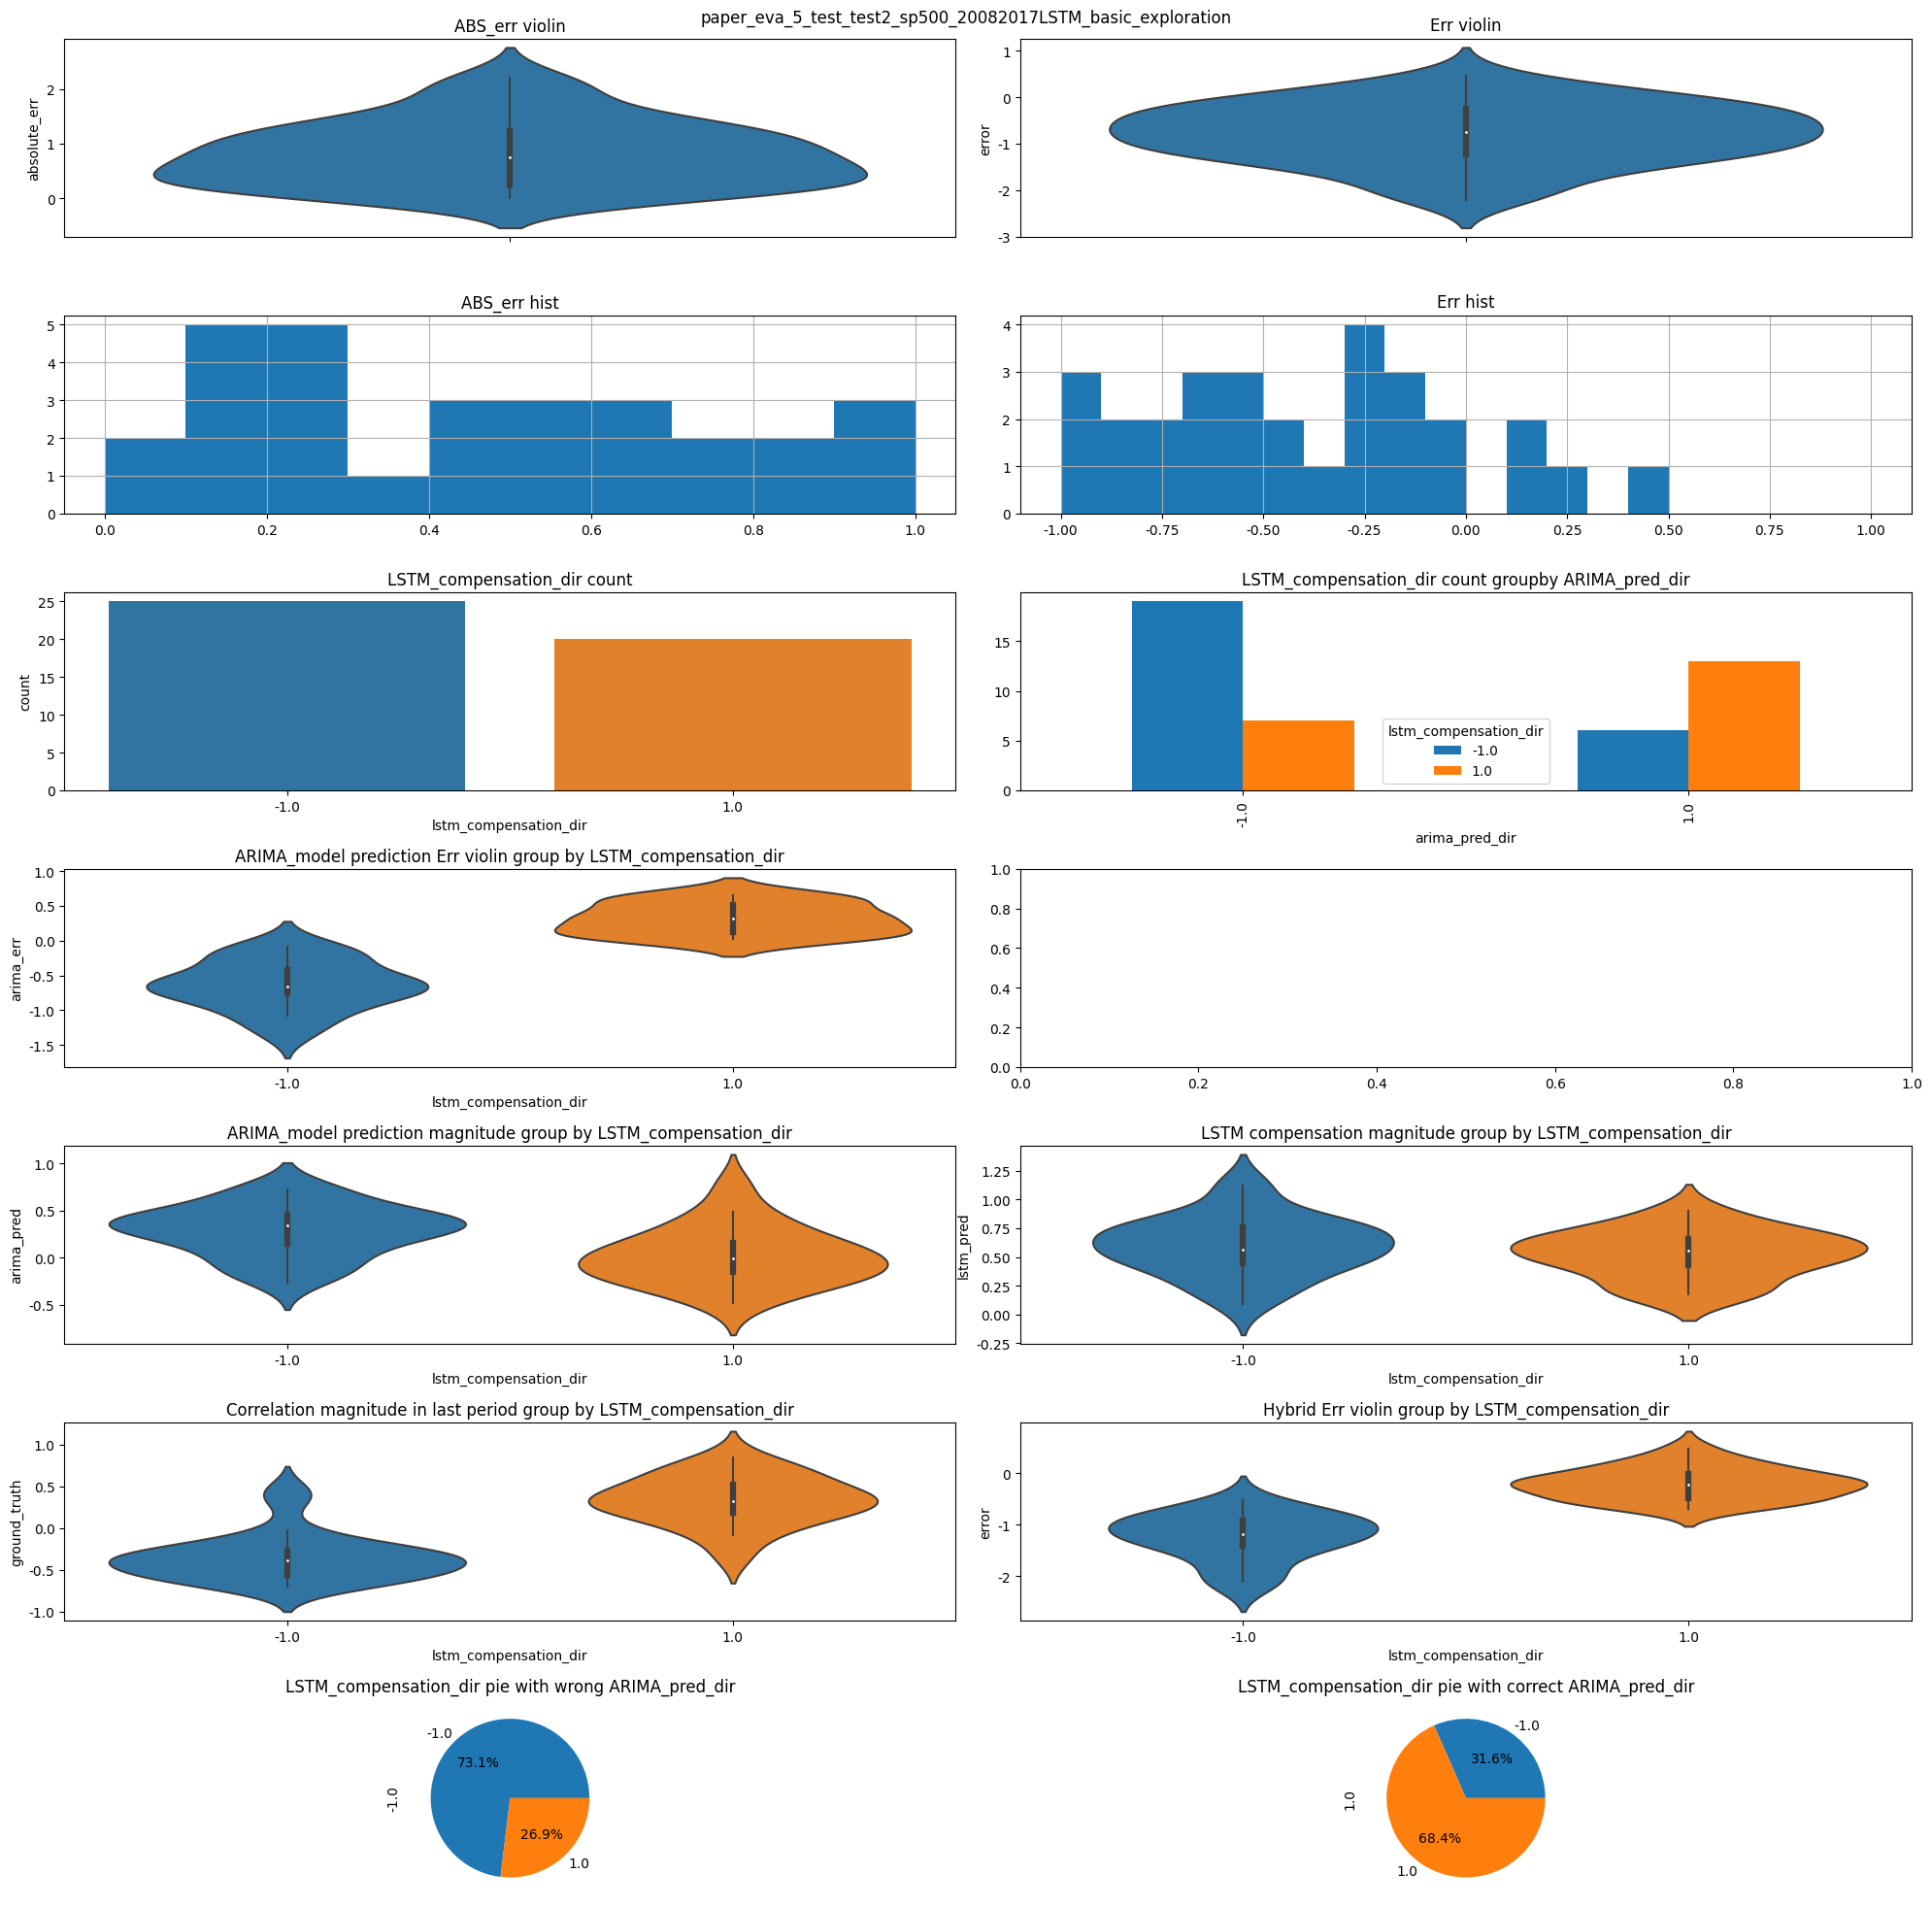

time: 1.67 s (started: 2022-09-28 17:25:09 +00:00)


In [16]:
plot_exploration(res_df, fig_title)

---

In [17]:
def plot_exploration_pred_perform(target_df: pd.core.frame.DataFrame, title: str) -> None:
    fig, axes = plt.subplots(figsize=(20, 20), nrows=6, ncols=2, sharex=False, sharey=False, dpi=100)
    s1 = axes[0, 0]
    s1.set_title("LSTM_compensation_dir count groupby prediction performance")
    df_gb = target_df.groupby(['high_pred_performance', 'lstm_compensation_dir']).size().unstack(level=1)
    df_gb.plot(kind='bar', ax=s1)
    s2 = axes[0, 1]
    s2.set_title("ARIMA_model prediction magnitude group by prediction performance")
    sns.violinplot(x=target_df["high_pred_performance"], y=target_df["arima_pred"], ax=s2)
    s3 = axes[1, 0]
    s3.set_title("LSTM compensation magnitude group by prediction performance")
    sns.violinplot(x=target_df["high_pred_performance"], y=target_df["lstm_pred"], ax=s3)
    s4 = axes[1, 1]
    s4.set_title("Correlation magnitude in last period group by prediction performance")
    sns.violinplot(x=target_df["high_pred_performance"], y=target_df["ground_truth"], ax=s4)
    s5 = axes[2, 0]
    s5.set_title("Correlation series mean groupby prediction performance")
    sns.violinplot(x=target_df['high_pred_performance'], y=target_df["corr_ser_mean"], ax=s5)
    s6 = axes[2, 1]
    s6.set_title("Correlation series std groupby prediction performance")
    sns.violinplot(x=target_df['high_pred_performance'], y=target_df["corr_ser_std"], ax=s6)
    s7 = axes[3, 0]
    s7.set_title("Correlation series stl_period group by prediction performance")
    sns.violinplot(x=target_df["high_pred_performance"], y=target_df["corr_season_period"], ax=s7)
    s8 = axes[3, 1]
    s8.set_title("Correlation series stl_residual group by prediction performance")
    sns.violinplot(x=target_df["high_pred_performance"], y=target_df["corr_stl_resid"], ax=s8)
    s9 = axes[4, 0]
    s9.set_title("Correlation series stl_trend_std group by prediction performance")
    sns.violinplot(x=target_df["high_pred_performance"], y=target_df["corr_stl_trend_std"], ax=s9)
    s10 = axes[4, 1]
    s10.set_title("Correlation series stl_trend_coef group by prediction performance")
    sns.violinplot(x=target_df["high_pred_performance"], y=target_df["corr_trend_coef"], ax=s10)
    s11 = axes[5, 0]
    s11.set_title("ARIMA_pred_dir count groupby prediction performance")
    df_gb = target_df.groupby(['high_pred_performance', 'arima_pred_dir']).size().unstack(level=1)
    df_gb.plot(kind='bar', ax=s11)

    fig.suptitle(F"{title}_groupby prediction")
    plt.tight_layout()
    plt.savefig(f"./results/hybrid_prediction_analysis_groupby_pred_perform_{title}.png")
    plt.show()
    plt.close()

time: 1.61 ms (started: 2022-09-28 17:25:10 +00:00)


In [18]:
def plot_stock_freq(target_df: pd.core.frame.DataFrame, title: str) -> None:
    stocks_show_freq = target_df.loc[target_df['high_pred_performance'] == True, ['items[0]','items[1]']].stack().value_counts().to_dict()
    plt.figure(figsize=(80, 10), dpi=100)
    plt.bar(range(len(stocks_show_freq)), list(stocks_show_freq.values()))
    plt.xticks(range(len(stocks_show_freq)), list(stocks_show_freq.keys()), rotation=60)
    plt.title(F"{title}_items appearence frequence")
    plt.savefig(f"./results/items_appearence_frequence_{title}.png")
    plt.show()
    plt.close()

time: 654 µs (started: 2022-09-28 17:25:10 +00:00)


In [19]:
display(f"mse :{(res_df['error']**2).mean()}",
        f"std of square_err :{(res_df['error']**2).std()}",
        f"rmse :{np.sqrt((res_df['error']**2).mean())}",
        f"mae : {res_df['absolute_err'].mean()}",
        f"std of abs_err: {res_df['absolute_err'].std()}",
        f"sklearn mse: {mean_squared_error(res_df['ground_truth'], res_df['hybrid_model_pred'])}")
display("-"*50)
display(f"mse of ARIMA :{(res_df['arima_err']**2).mean()}",
        f"std of square_err ARIMA :{(res_df['arima_err']**2).std()}",
        f"rmse of ARIMA :{np.sqrt((res_df['arima_err']**2).mean())}",
        f"sklearn mse of ARIMA: {mean_squared_error(res_df['ground_truth'], res_df['arima_pred'])}")

'mse :1.0151760895080408'

'std of square_err :1.2299647554583744'

'rmse :1.0075594719459695'

'mae : 0.8226993928331232'

'std of abs_err: 0.5882443241294446'

'sklearn mse: 1.0151760895080408'

'--------------------------------------------------'

'mse of ARIMA :0.3543404761666401'

'std of square_err ARIMA :0.41112997936938694'

'rmse of ARIMA :0.595265046988852'

'sklearn mse of ARIMA: 0.3543404761666401'

time: 8.7 ms (started: 2022-09-28 17:25:10 +00:00)


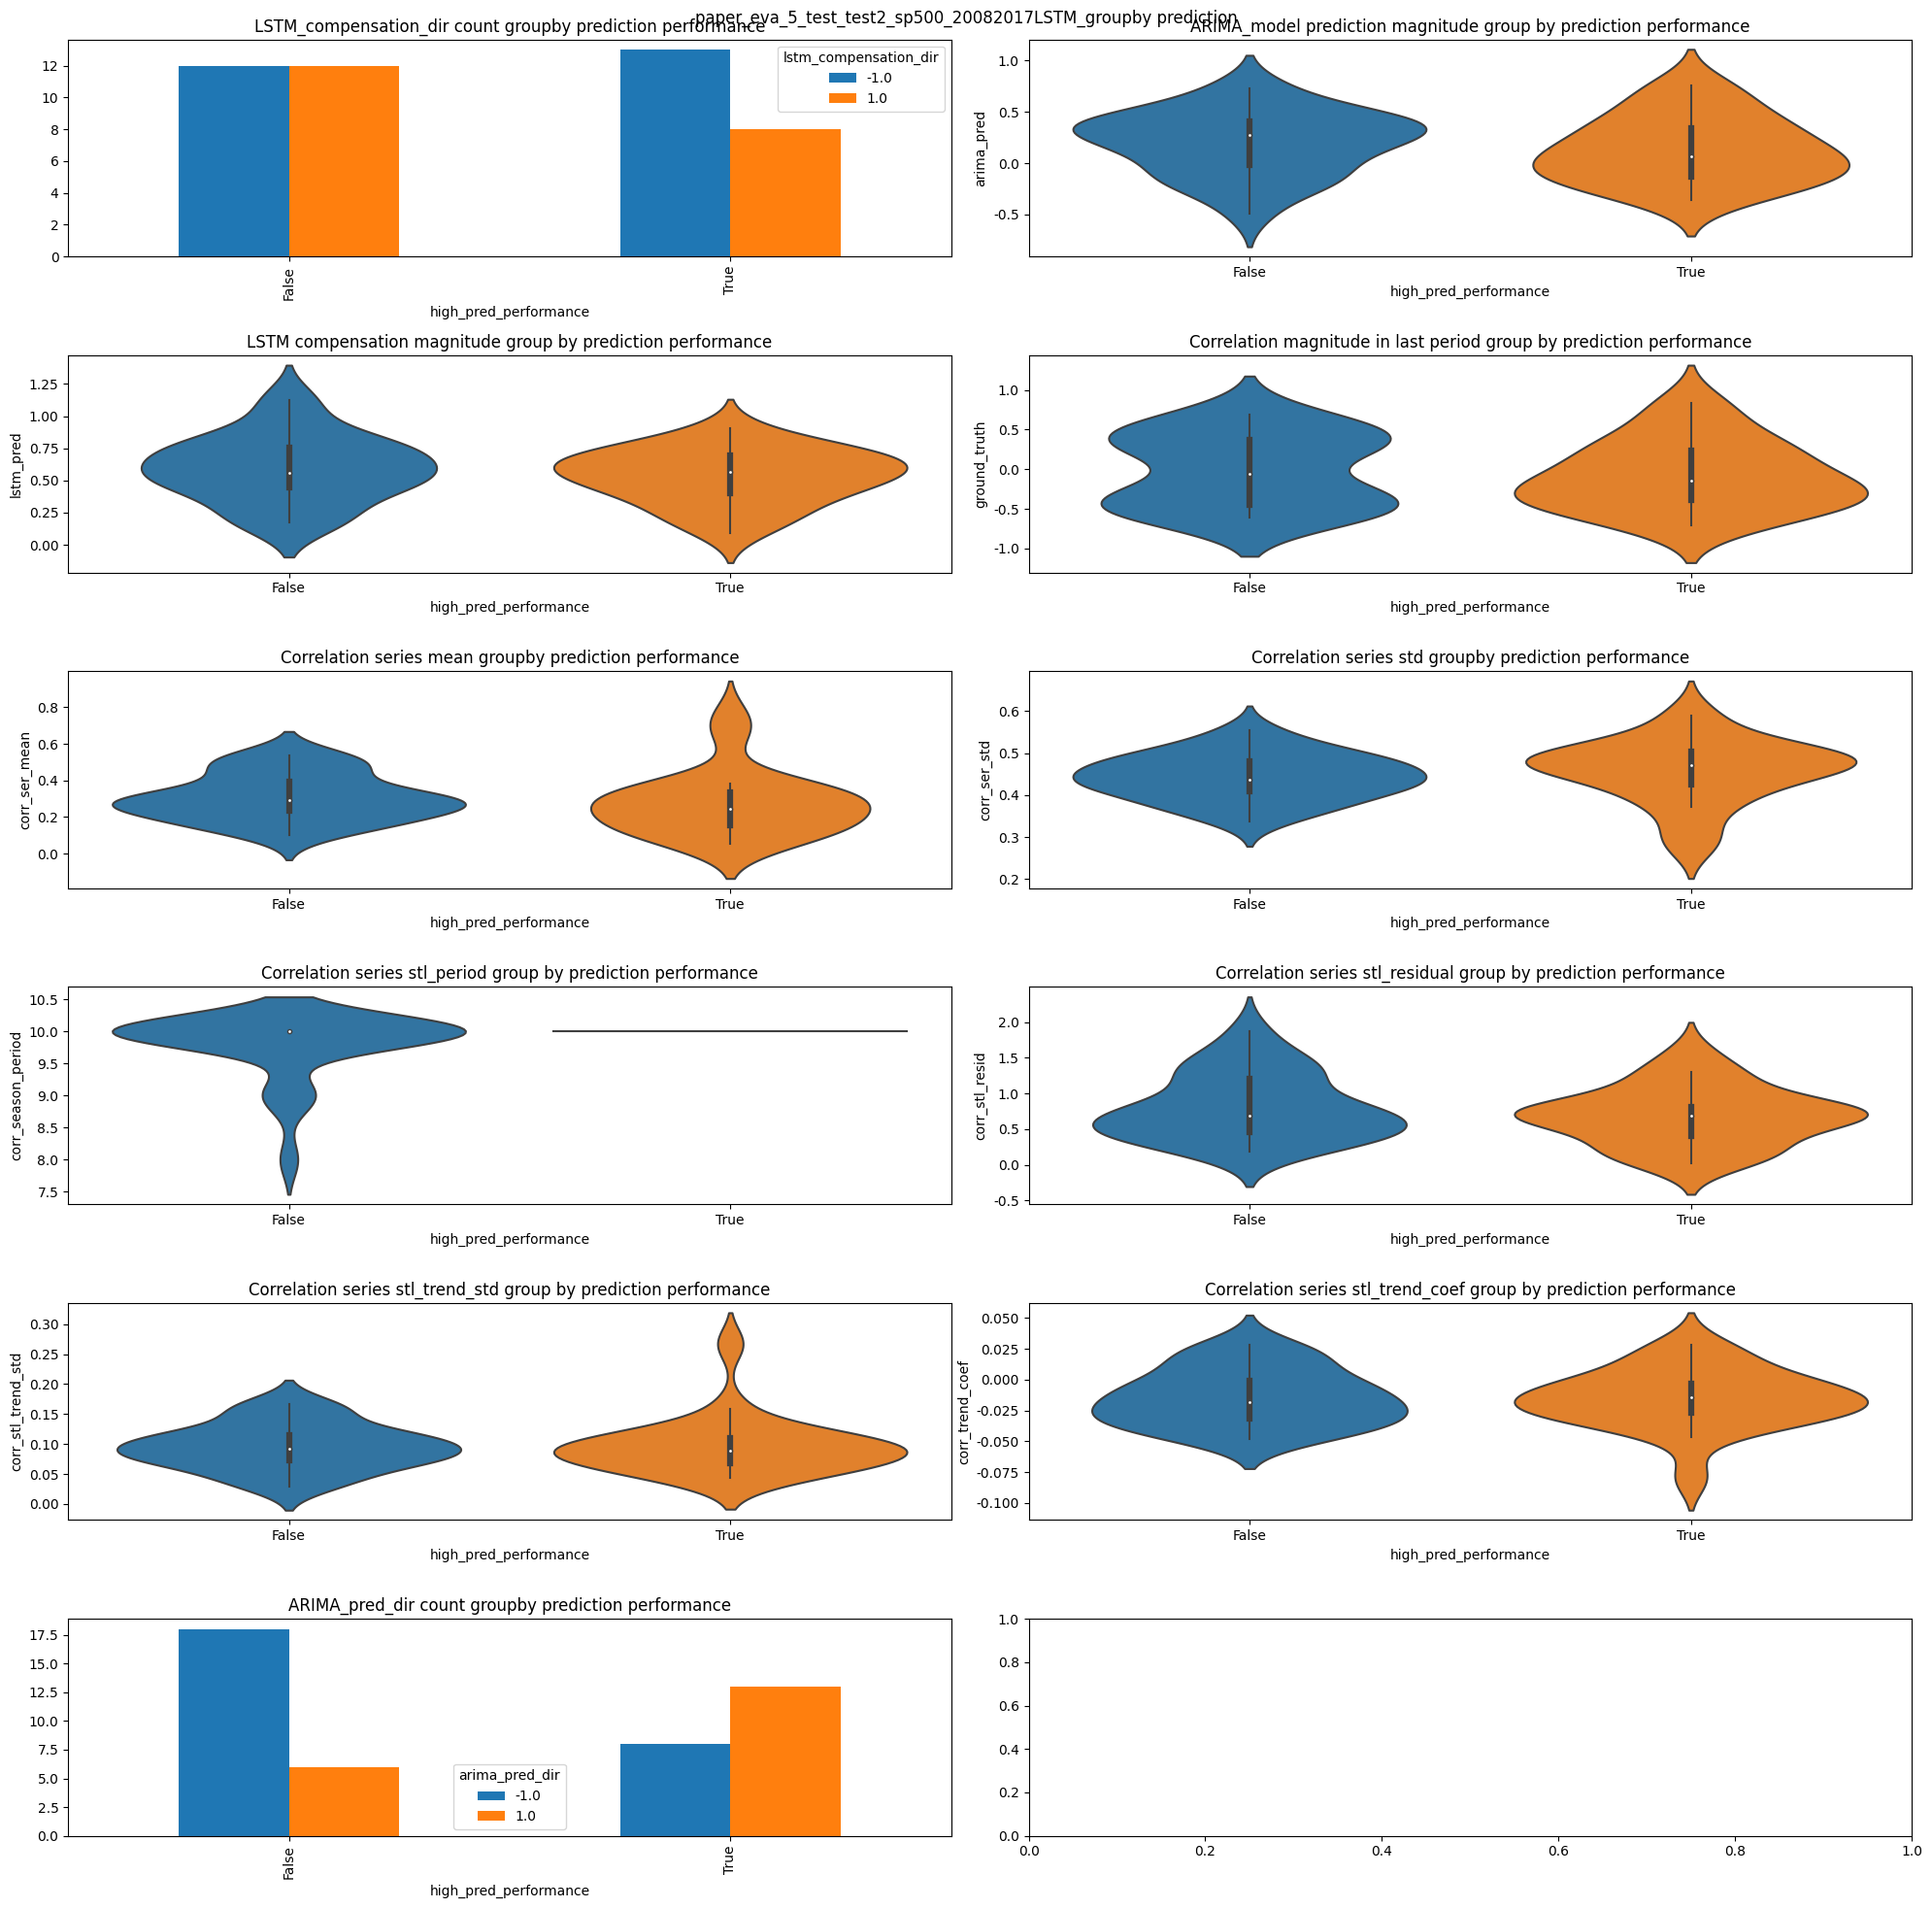

time: 1.59 s (started: 2022-09-28 17:25:10 +00:00)


In [20]:
plot_exploration_pred_perform(res_df, fig_title)

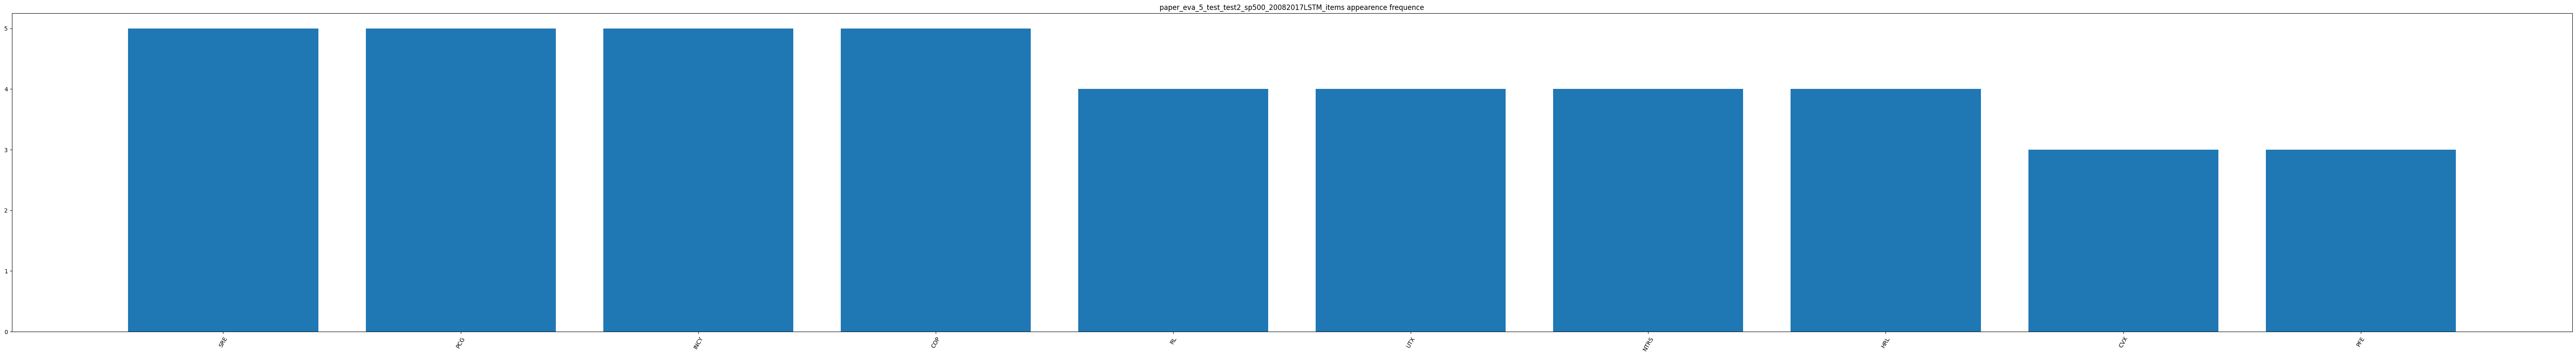

time: 626 ms (started: 2022-09-28 17:25:12 +00:00)


In [21]:
plot_stock_freq(res_df, fig_title)